In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.svm import SVC
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/Twitter_Data.csv.zip'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Loading the dataset

```
# This is formatted as code
```



In [ ]:
twitter=pd.read_csv('/content/Twitter_Data.csv.zip')
twitter.head(5)

clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0

In [ ]:
twitter['category'] = twitter['category'].replace({-1: 'negative', 0: 'neutral', 1: 'positive'})

In [ ]:
twitter.head()

clean_text  category
0  when modi promised “minimum government maximum...  negative
1  talk all the nonsense and continue all the dra...   neutral
2  what did just say vote for modi  welcome bjp t...  positive
3  asking his supporters prefix chowkidar their n...  positive
4  answer who among these the most powerful world...  positive

In [ ]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162976 non-null  object
 1   category    162973 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB


In [ ]:
twitter.isna().sum()

clean_text    4
category      7
dtype: int64

In [ ]:
twitter.dropna(subset=['clean_text', 'category'], inplace=True)

Creating a word cloud to view the most appearing word

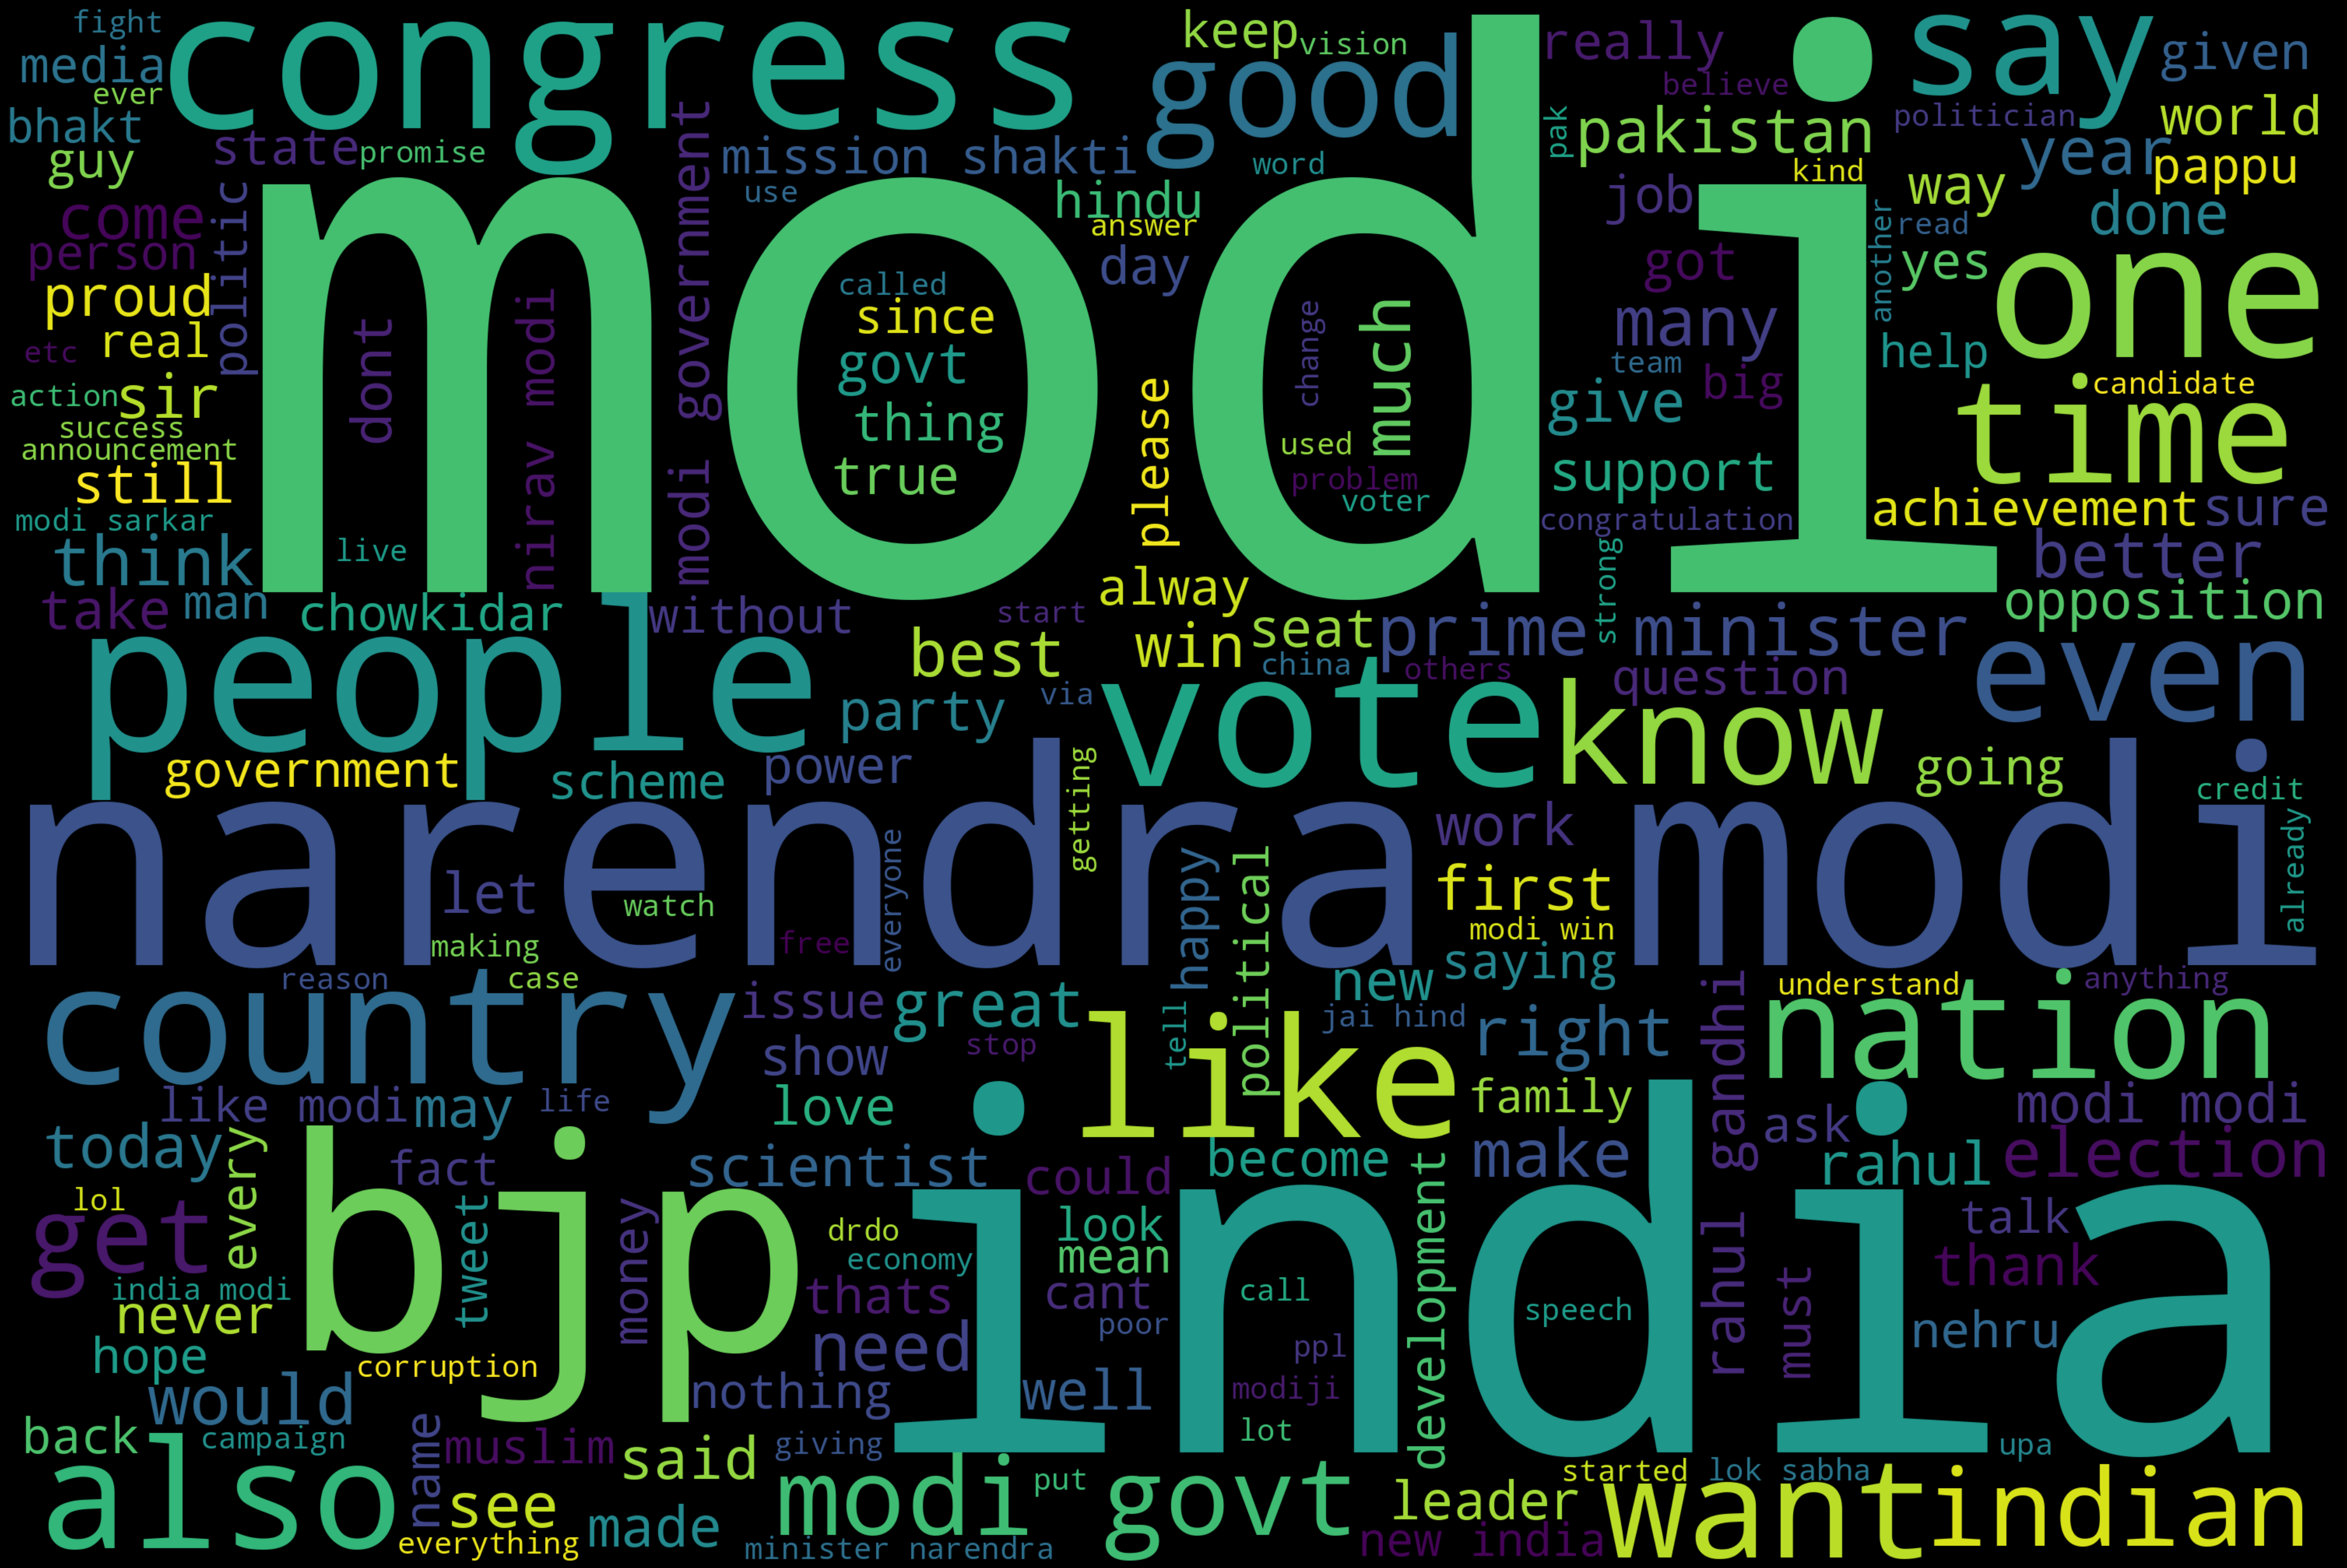

In [ ]:
text = ''

for tweet in twitter[twitter['category'] == "positive"]['clean_text']:
    text += f" {tweet}"

wordcloud = WordCloud(
width=3000, height=2000, background_color='black',
stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

fig = plt.figure(figsize=(40,30), facecolor='k',edgecolor='k')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show

del text

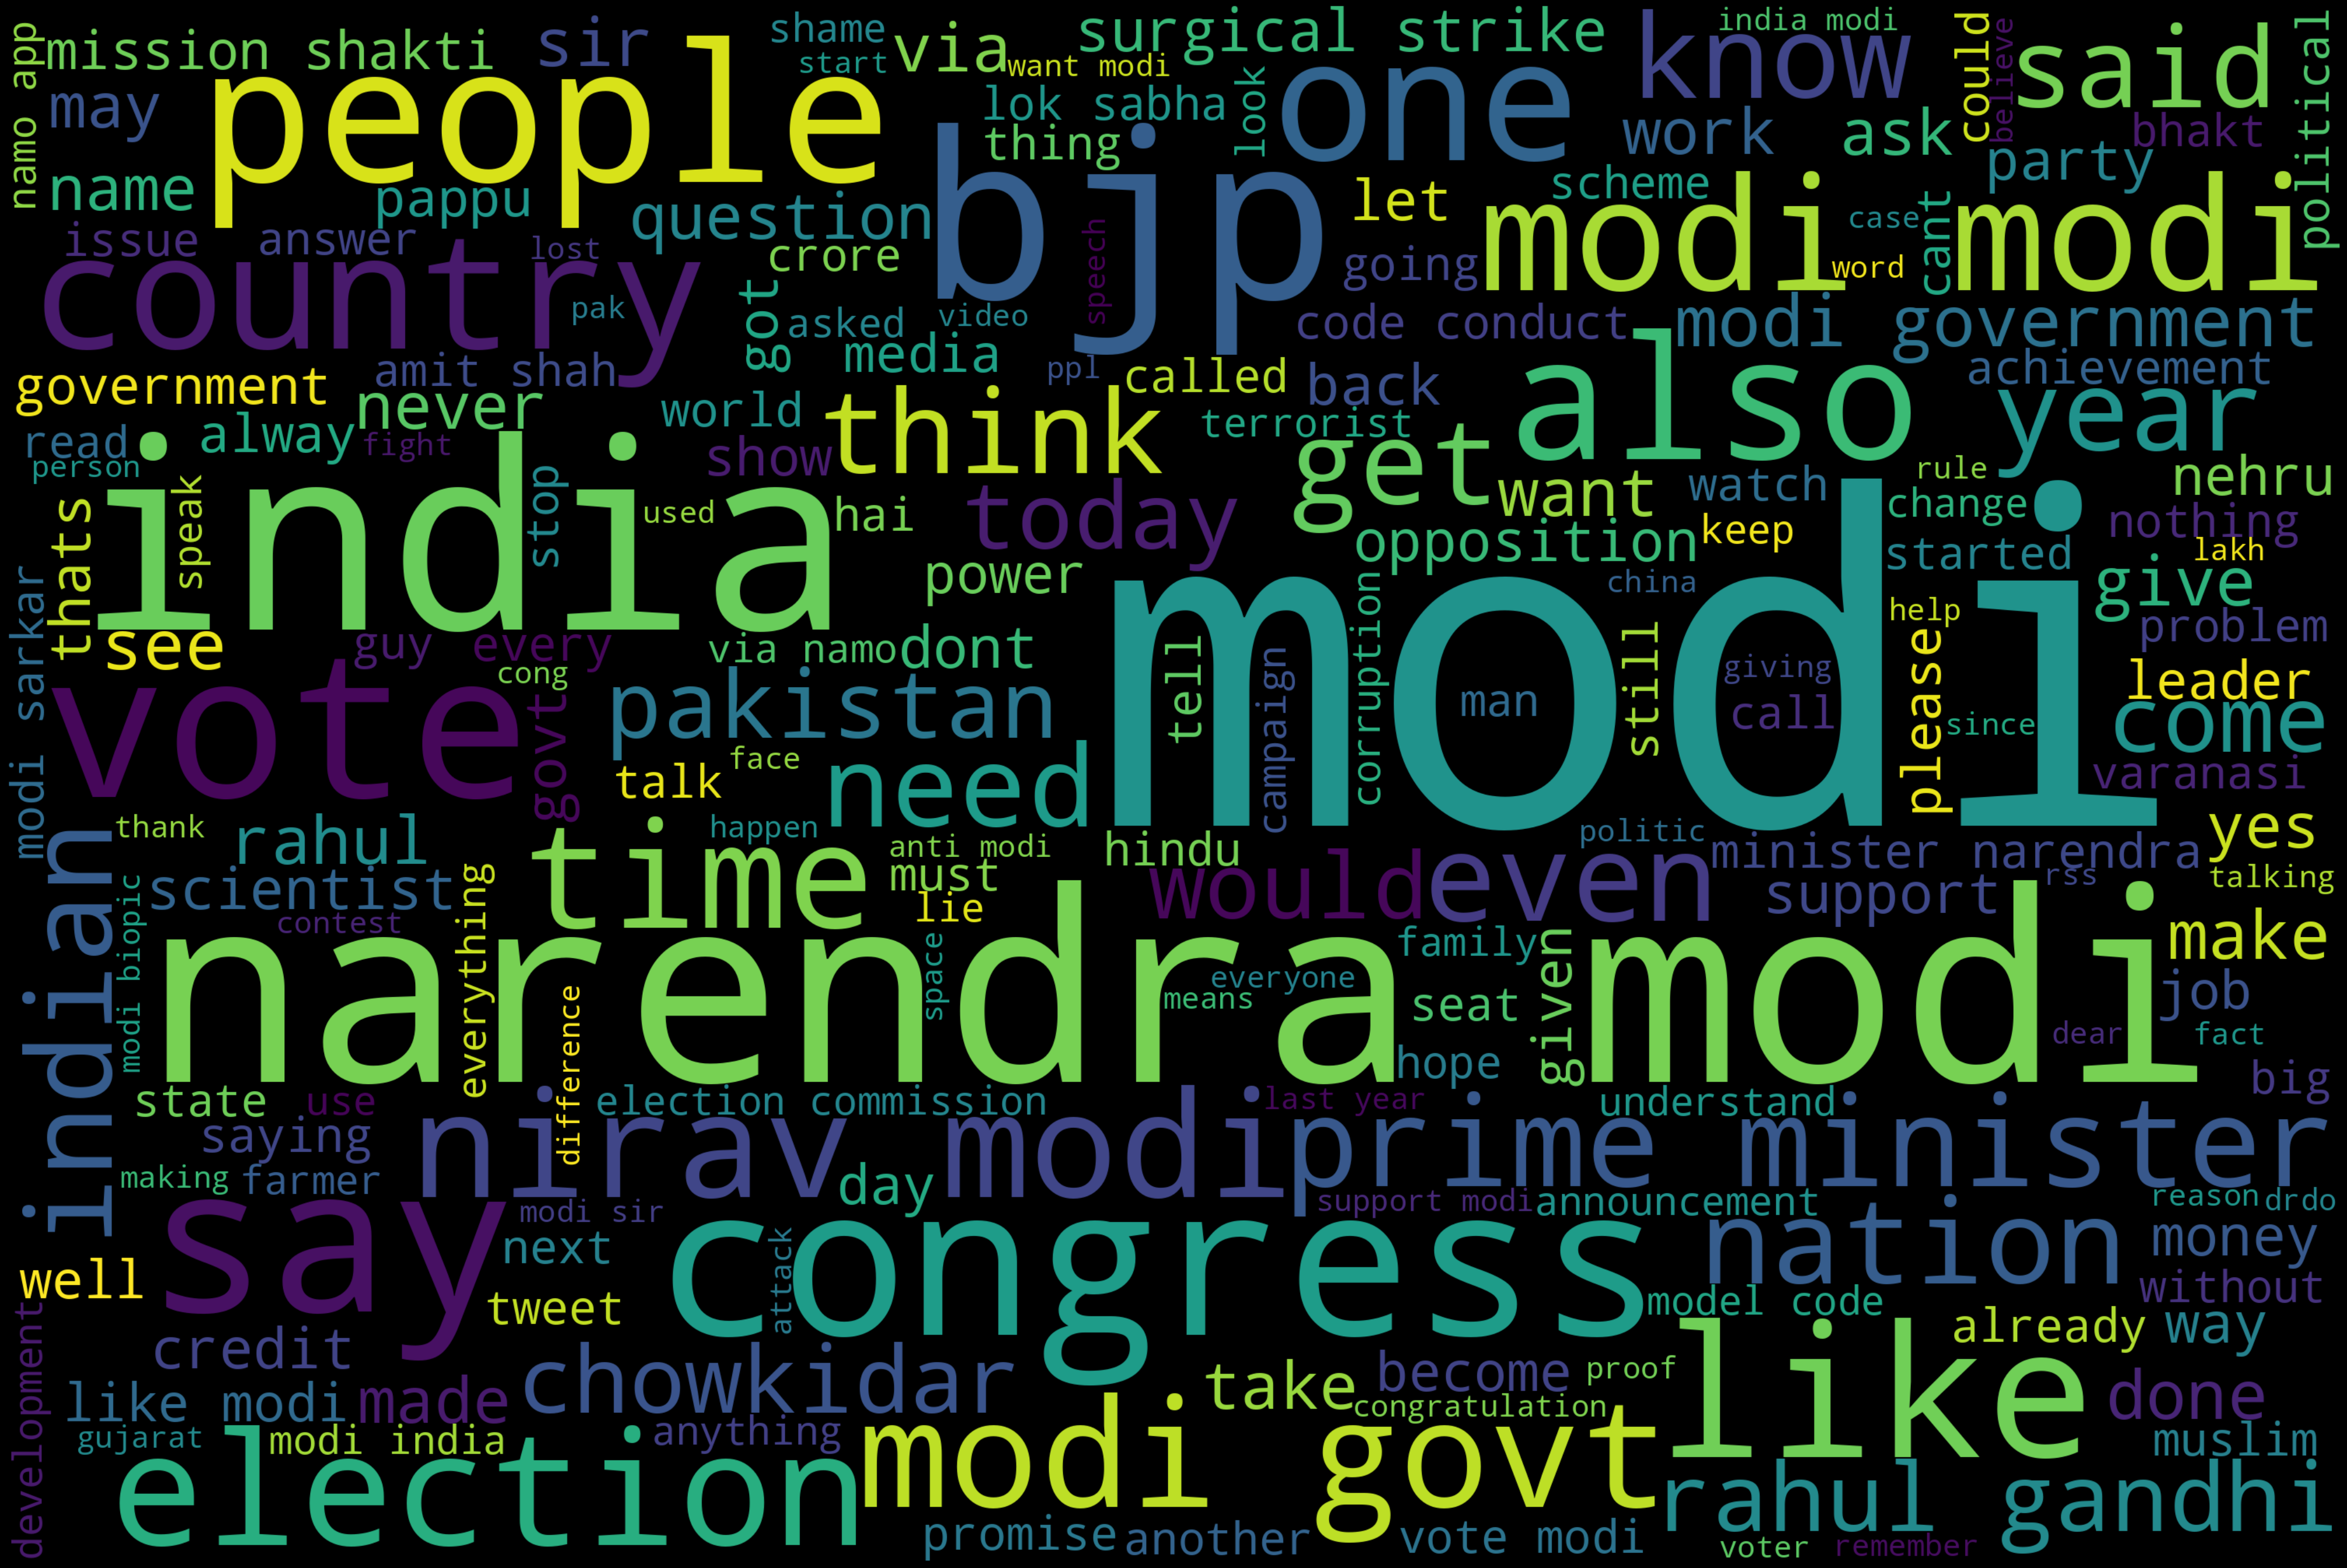

In [ ]:
text = ''

for tweet in twitter[twitter['category'] == "neutral"]['clean_text']:
    text += f" {tweet}"

wordcloud = WordCloud(
width=3000, height=2000, background_color='black',
stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

fig = plt.figure(figsize=(40,30), facecolor='k',edgecolor='k')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show

del text

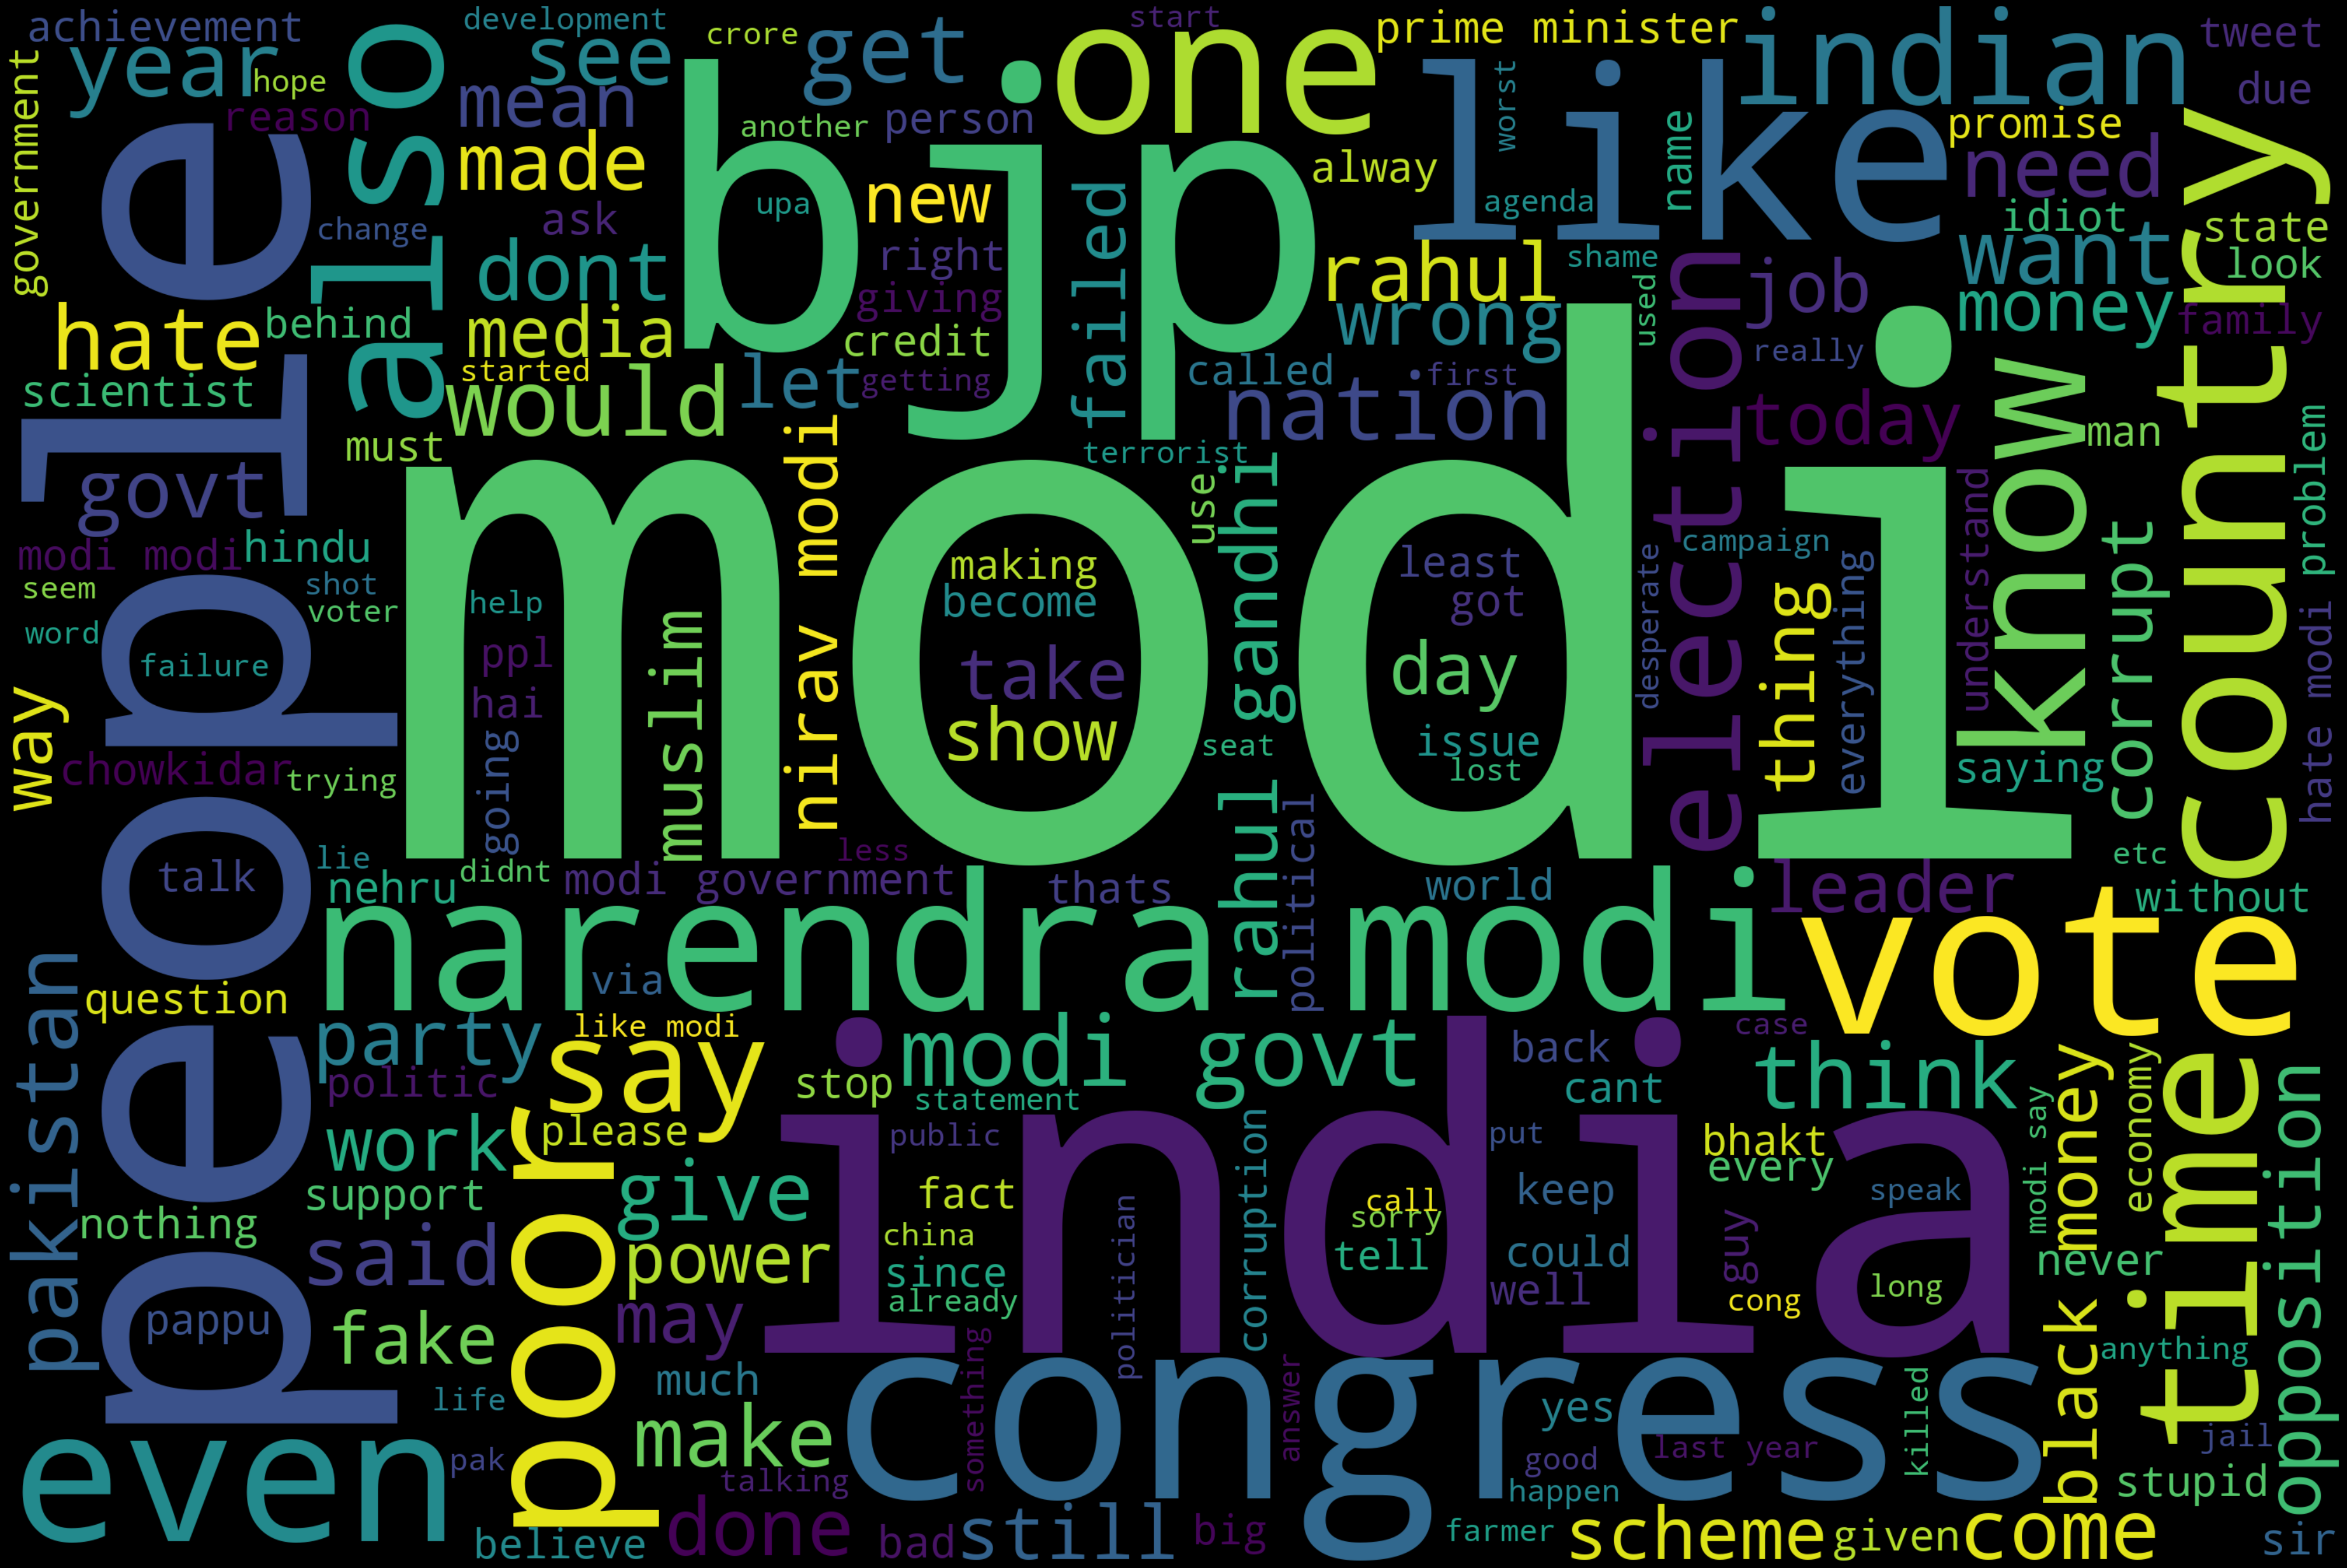

In [ ]:
text = ''

for tweet in twitter[twitter['category'] == "negative"]['clean_text']:
    text += f" {tweet}"

wordcloud = WordCloud(
width=3000, height=2000, background_color='black',
stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

fig = plt.figure(figsize=(40,30), facecolor='k',edgecolor='k')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show

del text

In [ ]:
print(twitter['category'].value_counts())

category
positive    72249
neutral     55211
negative    35509
Name: count, dtype: int64


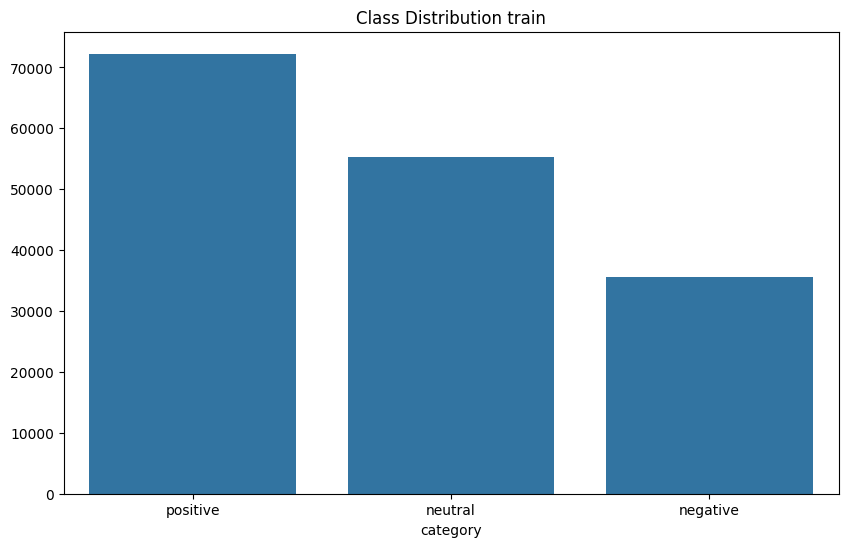

In [ ]:
dist = twitter['category'].value_counts()
def distribution_plot(x, y, name):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=x, y=y)
    plt.title(name)
    plt.show()

distribution_plot(x=dist.index, y=dist.values, name='Class Distribution train')

Using polarity and subjectivity

In [ ]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

twitter['polarity'] = twitter['clean_text'].apply(pol)
twitter['subjectivity'] = twitter['clean_text'].apply(sub)
twitter

clean_text  category  polarity  \
0       when modi promised “minimum government maximum...  negative -0.300000   
1       talk all the nonsense and continue all the dra...   neutral  0.000000   
2       what did just say vote for modi  welcome bjp t...  positive  0.483333   
3       asking his supporters prefix chowkidar their n...  positive  0.150000   
4       answer who among these the most powerful world...  positive  0.400000   
...                                                   ...       ...       ...   
162975  why these 456 crores paid neerav modi not reco...  negative -0.291667   
162976  dear rss terrorist payal gawar what about modi...  negative -0.195833   
162977  did you cover her interaction forum where she ...   neutral  0.000000   
162978  there big project came into india modi dream p...   neutral  0.000000   
162979  have you ever listen about like gurukul where ...  positive  0.350000   

        subjectivity  
0           0.700000  
1           0.000000  
2           0.616667  
3           0.658333  
4           0.750000  
...              ...  
162975      0.541667  
162976      0.433333  
162977      0.000000  
162978      0.100000  
162979      0.650000  

[162969 rows x 4 columns]

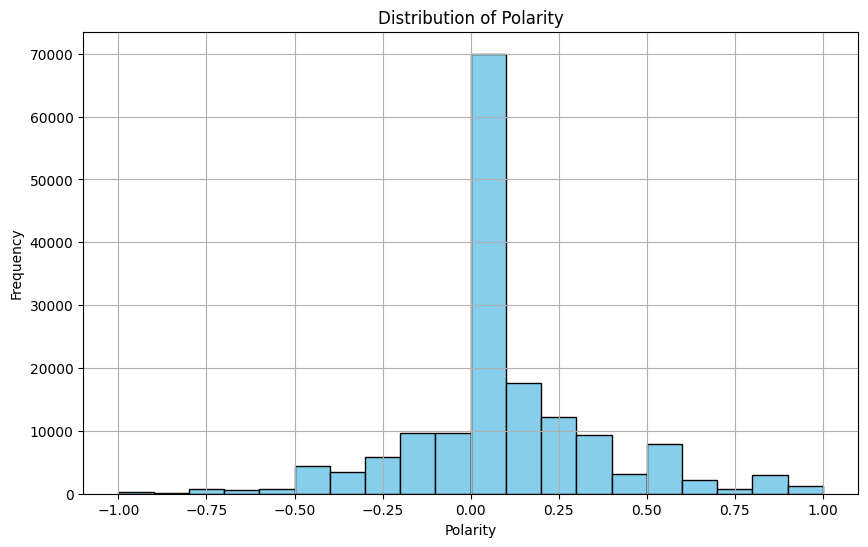

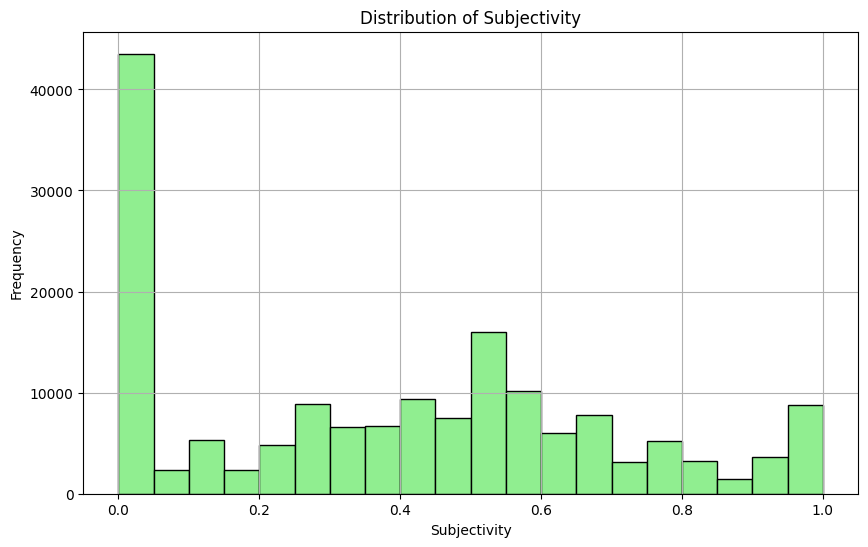

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(twitter['polarity'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Polarity')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot Subjectivity
plt.figure(figsize=(10, 6))
plt.hist(twitter['subjectivity'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Subjectivity')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Using TF-IDF for text vectorization and logistic regression for model training

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(twitter['clean_text'])

# Encode target labels (category) directly into numeric values
y = twitter['category'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression classifier
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict on test set
y_pred = lr.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.926182733018347
F1 Score: 0.9253437388434984
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87      7152
           1       0.92      0.98      0.95     11067
           2       0.94      0.94      0.94     14375

    accuracy                           0.93     32594
   macro avg       0.92      0.91      0.92     32594
weighted avg       0.93      0.93      0.93     32594

Confusion Matrix:
 [[ 5910   513   729]
 [   86 10825   156]
 [  475   447 13453]]


Training the model with Naive Bayes

In [ ]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predict on test set
y_pred_nb = nb.predict(X_test)

# Evaluate the classifier
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes F1 Score:", f1_score(y_test, y_pred_nb, average='weighted'))
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Naive Bayes Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.7373442964962876
Naive Bayes F1 Score: 0.7245100426825176
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.42      0.57      7152
           1       0.88      0.67      0.76     11067
           2       0.65      0.95      0.78     14375

    accuracy                           0.74     32594
   macro avg       0.81      0.68      0.70     32594
weighted avg       0.79      0.74      0.72     32594

Naive Bayes Confusion Matrix:
 [[ 2982   539  3631]
 [   92  7368  3607]
 [  208   484 13683]]
